# NSGA-II Benchmark Notebook

This notebook mirrors `nsgaii_main_experiments` but focuses exclusively on NSGA-II running on standard benchmark problems with two or three objectives (ZDT1, DTLZ2, WFG1). Every internal backend (NumPy, Numba, MooCore, MooCore_V2 when present) is swept alongside optional external NSGA-II baselines (PyMOO, jMetalPy, PyGMO). For each combination we log runtime, evaluations-per-second, hypervolume, and spread, plus generate per-problem comparisons and an aggregate backend summary.

In [37]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

from algorithm.config import NSGAIIConfig
from algorithm.nsgaii import NSGAII
from algorithm.hypervolume import hypervolume
from problem.zdt1 import ZDT1Problem
from problem.dtlz import DTLZ2Problem

try:
    from problem.wfg import WFG1Problem
except ImportError:
    WFG1Problem = None

from kernel.numpy_backend import NumPyKernel

try:
    from kernel.numba_backend import NumbaKernel
except ImportError:
    NumbaKernel = None

try:
    from kernel.moocore_backend import MooCoreKernel, MooCoreKernelV2
except ImportError:
    MooCoreKernel = None
    MooCoreKernelV2 = None

try:
    from pymoo.algorithms.moo.nsga2 import NSGA2 as PyMooNSGA2
    from pymoo.optimize import minimize as pymoo_minimize
    from pymoo.problems import get_problem as pymoo_get_problem
    from pymoo.operators.sampling.rnd import FloatRandomSampling as PyMooSampling
    from pymoo.operators.crossover.sbx import SBX as PyMooSBX
    from pymoo.operators.mutation.pm import PM as PyMooPM
except ImportError:
    PyMooNSGA2 = None
    pymoo_minimize = None
    pymoo_get_problem = None

try:
    from jmetal.algorithm.multiobjective.nsgaii import NSGAII as JMetalNSGAII
    from jmetal.problem.multiobjective.zdt import ZDT1 as JMetalZDT1
    from jmetal.problem.multiobjective.dtlz import DTLZ2 as JMetalDTLZ2
    from jmetal.problem.multiobjective.wfg import WFG1 as JMetalWFG1
    from jmetal.operator.crossover import SBXCrossover as JMetalSBX
    from jmetal.operator.mutation import PolynomialMutation as JMetalPM
    from jmetal.util.termination_criterion import StoppingByEvaluations
except ImportError:
    JMetalNSGAII = None
    JMetalZDT1 = None
    JMetalDTLZ2 = None
    JMetalWFG1 = None
    JMetalSBX = None
    JMetalPM = None
    StoppingByEvaluations = None

try:
    import pygmo as pg
except ImportError:
    pg = None

plt.style.use("seaborn-v0_8-darkgrid")

In [38]:
POPULATION_SIZE = 100
MAX_EVALUATIONS = 25000
SEED = 42
HV_OFFSET_DEFAULT = 0.1


def _make_wfg1_problem(n_var=24, n_obj=3):
    if WFG1Problem is None:
        raise ImportError("WFG1Problem requires pymoo; install pymoo to enable this benchmark.")
    return WFG1Problem(n_var=n_var, n_obj=n_obj)


BACKEND_FACTORIES = {
    "numpy": lambda: NumPyKernel,
}
if NumbaKernel is not None:
    BACKEND_FACTORIES["numba"] = lambda: NumbaKernel
if MooCoreKernel is not None:
    BACKEND_FACTORIES["moocore"] = lambda: MooCoreKernel
# if MooCoreKernelV2 is not None:
#     BACKEND_FACTORIES["moocore_v2"] = lambda: MooCoreKernelV2

EXTERNAL_RUNNERS = {
    "pymoo_nsga2": PyMooNSGA2 is not None,
    "jmetalpy_nsga2": JMetalNSGAII is not None,
    "pygmo_nsga2": pg is not None,
}

PROBLEMS = [
    {
        "id": "zdt1",
        "label": "ZDT1 (2 obj)",
        "n_var": 30,
        "n_obj": 2,
        "hv_offset": 0.1,
        "pymoo_pass_n_obj": False,
        "factory": lambda n_var=30: ZDT1Problem(n_var=n_var),
        "pymoo_id": "zdt1",
        "pymoo_kwargs": {"n_var": 30},
        "jmetal_factory": (lambda cls=JMetalZDT1: cls(number_of_variables=30)) if JMetalZDT1 else None,
        "pygmo_factory": (lambda module=pg: module.problem(module.zdt(prob_id=1, dim=30))) if pg else None,
    },
    {
        "id": "dtlz2",
        "label": "DTLZ2 (3 obj)",
        "n_var": 12,
        "n_obj": 3,
        "hv_offset": 0.05,
        "factory": lambda n_var=12, n_obj=3: DTLZ2Problem(n_var=n_var, n_obj=n_obj),
        "pymoo_id": "dtlz2",
        "pymoo_kwargs": {"n_var": 12, "n_obj": 3},
        "jmetal_factory": (lambda cls=JMetalDTLZ2: cls(number_of_variables=12, number_of_objectives=3)) if JMetalDTLZ2 else None,
        "pygmo_factory": (lambda module=pg: module.problem(module.dtlz(prob_id=2, dim=12, f=3))) if pg else None,
    },
    {
        "id": "wfg1",
        "label": "WFG1 (3 obj)",
        "n_var": 24,
        "n_obj": 3,
        "hv_offset": 0.05,
        "factory": _make_wfg1_problem,
        "pymoo_id": "wfg1",
        "pymoo_kwargs": {"n_var": 24, "n_obj": 3, "k": 4, "l": 20},
        "jmetal_factory": (lambda cls=JMetalWFG1: cls(k=4, l=20, m=3)) if JMetalWFG1 else None,
        "pygmo_factory": (lambda module=pg: module.problem(module.wfg(prob_id=1, dim=24, k=4, f=3))) if pg else None,
    },
]

print("Internal backends:", ", ".join(BACKEND_FACTORIES.keys()))
available_ext = [name for name, ok in EXTERNAL_RUNNERS.items() if ok]
print("External frameworks:", ", ".join(available_ext) if available_ext else "none")

for spec in PROBLEMS:
    support = []
    if spec.get("pymoo_id"):
        support.append("PyMOO")
    if spec.get("jmetal_factory"):
        support.append("jMetalPy")
    if spec.get("pygmo_factory"):
        support.append("PyGMO")
    print(f"{spec['label']} externals:", ", ".join(support) if support else "none")

Internal backends: numpy, numba, moocore
External frameworks: pymoo_nsga2
ZDT1 (2 obj) externals: PyMOO
DTLZ2 (3 obj) externals: PyMOO
WFG1 (3 obj) externals: PyMOO


In [39]:
def build_metrics(problem_spec, label, backend, time_ms, evaluations, F, runner_type):
    F = np.asarray(F, dtype=float)
    spread = float(np.max(np.abs(np.ptp(F, axis=0)))) if F.size else np.nan
    return {
        "problem_id": problem_spec["id"],
        "problem_label": problem_spec["label"],
        "n_obj": problem_spec["n_obj"],
        "label": label,
        "backend": backend,
        "runner_type": runner_type,
        "time_ms": time_ms,
        "evaluations": evaluations,
        "evals_per_sec": evaluations / max(time_ms / 1000.0, 1e-9),
        "spread": spread,
        "F": F,
    }


def run_internal_nsga2(problem_spec, backend_name):
    factory = BACKEND_FACTORIES.get(backend_name)
    if factory is None:
        print(f"Skipping {backend_name}: backend not available")
        return None
    try:
        kernel_cls = factory()
    except Exception as exc:
        print(f"Skipping {backend_name}: failed to build kernel ({exc})")
        return None

    problem_factory = problem_spec.get("factory")
    if problem_factory is None:
        print(f"Skipping {problem_spec['label']} on {backend_name}: no problem factory defined")
        return None
    try:
        problem = problem_factory()
    except Exception as exc:
        print(f"Skipping {problem_spec['label']} on {backend_name}: {exc}")
        return None

    cfg = (
        NSGAIIConfig()
        .pop_size(POPULATION_SIZE)
        .crossover("sbx", prob=0.9, eta=20.0)
        .mutation("pm", prob="1/n", eta=20.0)
        .selection("tournament", pressure=2)
        .survival("nsga2")
        .engine(backend_name)
        .fixed()
    )

    algorithm = NSGAII(cfg, kernel=kernel_cls)
    start = time.perf_counter()
    result = algorithm.run(problem, termination=("n_eval", MAX_EVALUATIONS), seed=SEED)
    end = time.perf_counter()

    label = f"NSGA-II ({backend_name})"
    return build_metrics(problem_spec, label, backend_name, (end - start) * 1000.0, MAX_EVALUATIONS, result["F"], "internal")


def run_pymoo_nsga2(problem_spec):
    if PyMooNSGA2 is None or pymoo_minimize is None or pymoo_get_problem is None:
        print("Skipping PyMOO NSGA-II: pymoo not installed")
        return None
    problem_name = problem_spec.get("pymoo_id")
    if not problem_name:
        print(f"Skipping PyMOO NSGA-II: {problem_spec['label']} not mapped")
        return None
    kwargs = dict(problem_spec.get("pymoo_kwargs", {}))
    kwargs.setdefault("n_var", problem_spec["n_var"])
    if problem_spec.get("pymoo_pass_n_obj", True):
        kwargs.setdefault("n_obj", problem_spec["n_obj"])
    try:
        pymoo_problem = pymoo_get_problem(problem_name, **kwargs)
    except Exception as exc:
        print(f"Skipping PyMOO NSGA-II on {problem_spec['label']}: {exc}")
        return None

    mutation_prob = 1.0 / pymoo_problem.n_var
    algorithm = PyMooNSGA2(
        pop_size=POPULATION_SIZE,
        sampling=PyMooSampling(),
        crossover=PyMooSBX(prob=0.9, eta=20),
        mutation=PyMooPM(prob=mutation_prob, eta=20),
        eliminate_duplicates=True,
    )
    start = time.perf_counter()
    res = pymoo_minimize(
        pymoo_problem,
        algorithm,
        ("n_eval", MAX_EVALUATIONS),
        seed=SEED,
        verbose=False,
    )
    end = time.perf_counter()
    return build_metrics(problem_spec, "PyMOO NSGA-II", "pymoo", (end - start) * 1000.0, MAX_EVALUATIONS, res.F, "external")


def run_jmetalpy_nsga2(problem_spec):
    if JMetalNSGAII is None or JMetalPM is None or JMetalSBX is None or StoppingByEvaluations is None:
        print("Skipping jMetalPy NSGA-II: jmetalpy not installed")
        return None
    problem_factory = problem_spec.get("jmetal_factory")
    if problem_factory is None:
        print(f"Skipping jMetalPy on {problem_spec['label']}: not supported")
        return None
    try:
        problem = problem_factory()
    except Exception as exc:
        print(f"Skipping jMetalPy on {problem_spec['label']}: {exc}")
        return None

    mutation = JMetalPM(probability=1.0 / problem_spec["n_var"], distribution_index=20.0)
    crossover = JMetalSBX(probability=0.9, distribution_index=20.0)
    algorithm = JMetalNSGAII(
        problem=problem,
        population_size=POPULATION_SIZE,
        offspring_population_size=POPULATION_SIZE,
        mutation=mutation,
        crossover=crossover,
        termination_criterion=StoppingByEvaluations(max_evaluations=MAX_EVALUATIONS),
    )
    start = time.perf_counter()
    algorithm.run()
    end = time.perf_counter()
    solutions = algorithm.result()
    fronts = [sol.objectives for sol in solutions]
    return build_metrics(problem_spec, "jMetalPy NSGA-II", "jmetalpy", (end - start) * 1000.0, MAX_EVALUATIONS, fronts, "external")


def run_pygmo_nsga2(problem_spec):
    if pg is None:
        print("Skipping PyGMO NSGA-II: pygmo not installed")
        return None
    problem_factory = problem_spec.get("pygmo_factory")
    if problem_factory is None:
        print(f"Skipping PyGMO on {problem_spec['label']}: not supported")
        return None
    try:
        pg_problem = problem_factory()
    except Exception as exc:
        print(f"Skipping PyGMO on {problem_spec['label']}: {exc}")
        return None

    generations = max(1, (MAX_EVALUATIONS - POPULATION_SIZE) // POPULATION_SIZE)
    uda = pg.nsga2(
        gen=generations,
        seed=SEED,
        cr=0.9,
        eta_c=20.0,
        m=1.0 / problem_spec["n_var"],
        eta_m=20.0,
    )
    algo = pg.algorithm(uda)
    pop = pg.population(pg_problem, size=POPULATION_SIZE, seed=SEED)
    start = time.perf_counter()
    pop = algo.evolve(pop)
    end = time.perf_counter()
    total_eval = POPULATION_SIZE * (generations + 1)
    return build_metrics(problem_spec, "PyGMO NSGA-II", "pygmo", (end - start) * 1000.0, total_eval, pop.get_f(), "external")


EXTERNAL_RUNNER_FUNCS = {
    "pymoo_nsga2": run_pymoo_nsga2,
    "jmetalpy_nsga2": run_jmetalpy_nsga2,
    "pygmo_nsga2": run_pygmo_nsga2,
}

In [40]:
results = []

for problem_spec in PROBLEMS:
    print(f"### Problem: {problem_spec['label']}")
    for backend_name in BACKEND_FACTORIES.keys():
        print(f"Running NSGA-II ({backend_name})...")
        metrics = run_internal_nsga2(problem_spec, backend_name)
        if metrics is not None:
            results.append(metrics)
    for name, runner in EXTERNAL_RUNNER_FUNCS.items():
        if not EXTERNAL_RUNNERS.get(name, False):
            print(f"Skipping {name} on {problem_spec['label']}: framework unavailable")
            continue
        print(f"Running {name} on {problem_spec['label']}...")
        metrics = runner(problem_spec)
        if metrics is not None:
            results.append(metrics)

if not results:
    raise RuntimeError("No runs were executed. Install a backend or external framework and rerun.")

### Problem: ZDT1 (2 obj)
Running NSGA-II (numpy)...
Running NSGA-II (numba)...
Running NSGA-II (moocore)...
Running pymoo_nsga2 on ZDT1 (2 obj)...
Skipping jmetalpy_nsga2 on ZDT1 (2 obj): framework unavailable
Skipping pygmo_nsga2 on ZDT1 (2 obj): framework unavailable
### Problem: DTLZ2 (3 obj)
Running NSGA-II (numpy)...
Running NSGA-II (numba)...
Running NSGA-II (moocore)...
Running pymoo_nsga2 on DTLZ2 (3 obj)...
Skipping jmetalpy_nsga2 on DTLZ2 (3 obj): framework unavailable
Skipping pygmo_nsga2 on DTLZ2 (3 obj): framework unavailable
### Problem: WFG1 (3 obj)
Running NSGA-II (numpy)...
Running NSGA-II (numba)...
Running NSGA-II (moocore)...
Running pymoo_nsga2 on WFG1 (3 obj)...
Skipping jmetalpy_nsga2 on WFG1 (3 obj): framework unavailable
Skipping pygmo_nsga2 on WFG1 (3 obj): framework unavailable


In [41]:
hv_references = {}
summary_rows = []
hv_scales = {}

for spec in PROBLEMS:
    subset = [entry for entry in results if entry["problem_id"] == spec["id"]]
    if not subset:
        print(f"No data collected for {spec['label']} (skipping hypervolume)")
        continue
    hv_offset = spec.get("hv_offset", HV_OFFSET_DEFAULT)
    stacked_fronts = np.vstack([entry["F"] for entry in subset])
    hv_reference = stacked_fronts.max(axis=0) + hv_offset
    hv_references[spec["id"]] = hv_reference
    scale = float(np.max(np.abs(hv_reference)))
    if not np.isfinite(scale) or scale <= 0.0:
        scale = 1.0
    hv_scales[spec["id"]] = scale
    ref_scaled = hv_reference / scale
    for entry in subset:
        scaled_front = entry["F"] / scale
        entry["hypervolume"] = hypervolume(scaled_front, ref_scaled)
        summary_rows.append(
            {
                "Problem": spec["label"],
                "Runner": entry["label"],
                "Backend": entry["backend"],
                "Type": entry["runner_type"],
                "Evaluations": entry["evaluations"],
                "Time (ms)": entry["time_ms"],
                "Eval/s": entry["evals_per_sec"],
                "Hypervolume": entry["hypervolume"],
                "Spread": entry["spread"],
            }
        )
    print(
        f"Hypervolume reference ({spec['label']}): {np.round(hv_reference, 6)} | scale={scale:.3e}"
    )

summary_df = pd.DataFrame(summary_rows)
if not summary_df.empty:
    summary_df = summary_df.sort_values(["Problem", "Hypervolume"], ascending=[True, False]).reset_index(drop=True)
    display(summary_df)
    print(f"Collected {len(summary_df)} runs across {len(PROBLEMS)} problems.")
else:
    print("Summary dataframe is empty.")

Hypervolume reference (ZDT1 (2 obj)): [1.1      1.621053] | scale=1.621e+00
Hypervolume reference (DTLZ2 (3 obj)): [1.05003  1.050032 2.186527] | scale=2.187e+00
Hypervolume reference (WFG1 (3 obj)): [2.748452 1.621468 2.874656] | scale=2.875e+00


,Problem,Runner,Backend,Type,Evaluations,Time (ms),Eval/s,Hypervolume,Spread
0,DTLZ2 (3 obj),NSGA-II (numpy),numpy,internal,25000,494.3140,50575.140497,0.230619,0.000000
1,DTLZ2 (3 obj),NSGA-II (numba),numba,internal,25000,91.1667,274222.934460,0.029562,2.136527
2,DTLZ2 (3 obj),NSGA-II (moocore),moocore,internal,25000,121.2153,206244.591245,0.019155,2.136527
3,DTLZ2 (3 obj),PyMOO NSGA-II,pymoo,external,25000,871.5778,28683.612640,0.010996,1.000075
4,WFG1 (3 obj),NSGA-II (numpy),numpy,internal,25000,553.6900,45151.619139,0.539293,0.000000
5,WFG1 (3 obj),NSGA-II (numba),numba,internal,25000,129.3703,193243.735257,0.539293,0.000000
6,WFG1 (3 obj),NSGA-II (moocore),moocore,internal,25000,185.8579,134511.365934,0.539293,0.000000
7,WFG1 (3 obj),PyMOO NSGA-II,pymoo,external,25000,945.4365,26442.812394,0.003674,2.000729
8,ZDT1 (2 obj),PyMOO NSGA-II,pymoo,external,25000,892.4561,28012.582356,0.061622,1.012188
9,ZDT1 (2 obj),NSGA-II (numba),numba,internal,25000,82.5530,302835.753946,0.053282,1.178372


Collected 12 runs across 3 problems.


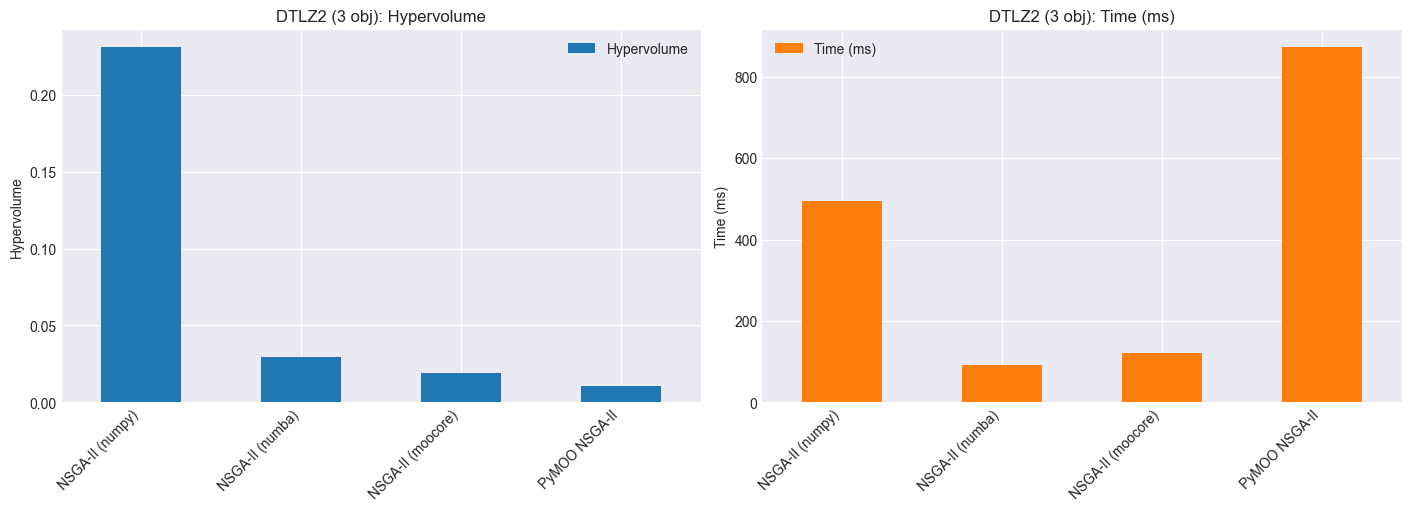

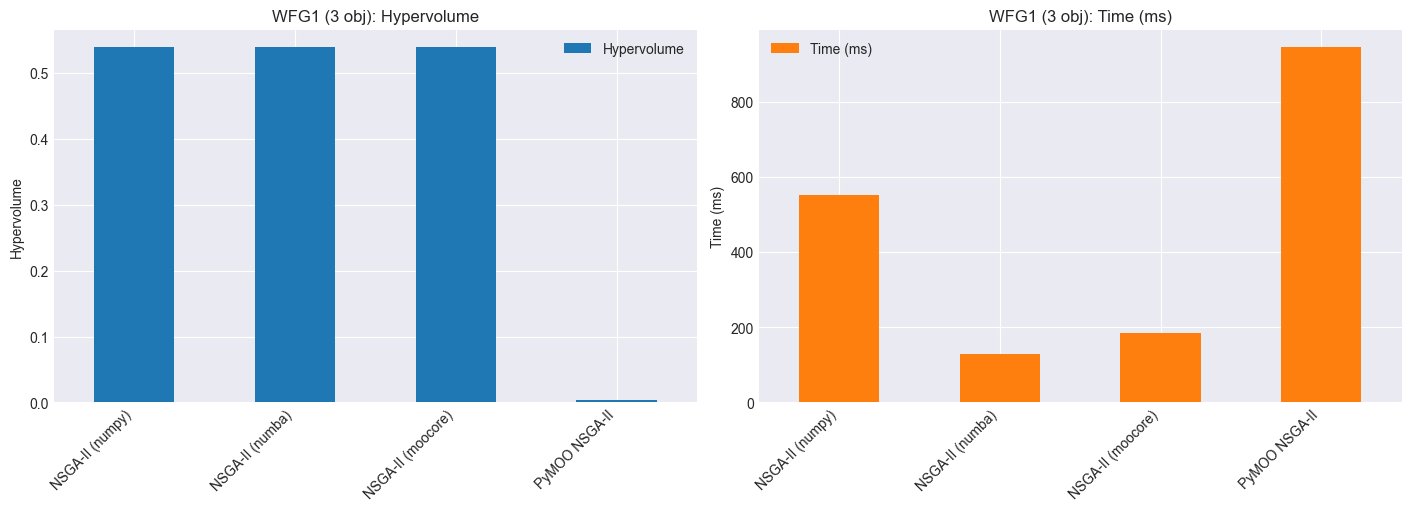

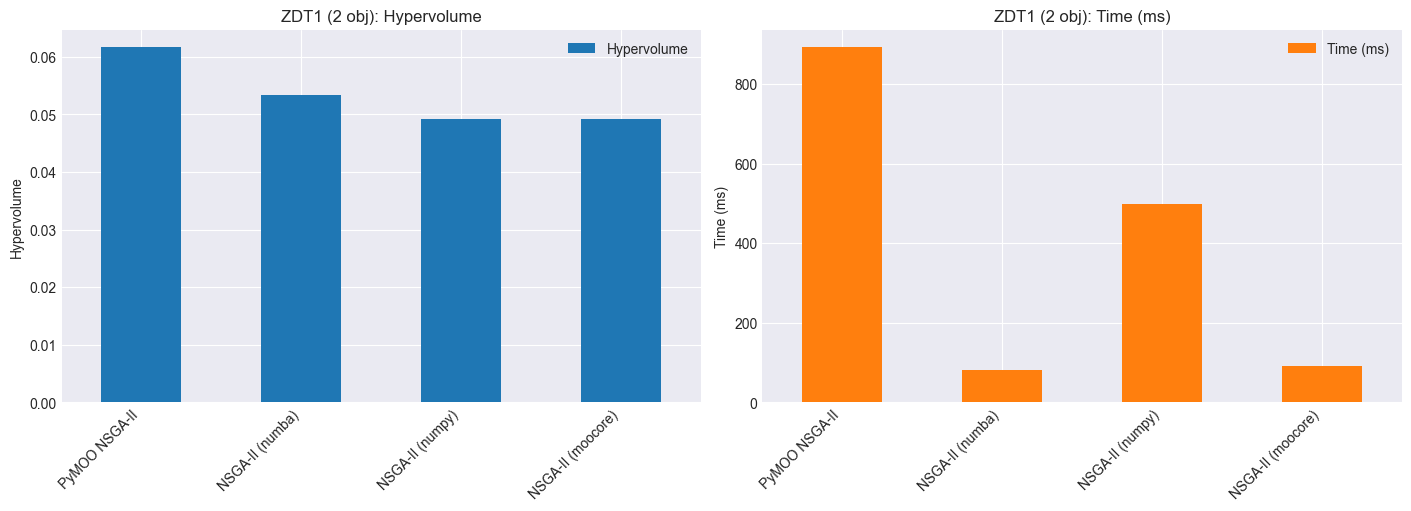

In [42]:
if summary_df.empty:
    raise RuntimeError("No summary data to plot.")

for problem_name, subset in summary_df.groupby("Problem"):
    subset_sorted = subset.sort_values("Hypervolume", ascending=False)
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)
    subset_sorted.plot.bar(x="Runner", y="Hypervolume", ax=axes[0], color="#1f77b4")
    axes[0].set_title(f"{problem_name}: Hypervolume")
    axes[0].set_ylabel("Hypervolume")
    axes[0].set_xlabel("")

    subset_sorted.plot.bar(x="Runner", y="Time (ms)", ax=axes[1], color="#ff7f0e")
    axes[1].set_title(f"{problem_name}: Time (ms)")
    axes[1].set_ylabel("Time (ms)")
    axes[1].set_xlabel("")

    for ax in axes:
        ax.tick_params(axis="x", rotation=45)
        for label in ax.get_xticklabels():
            label.set_horizontalalignment("right")

,Runs,Problems,Hypervolume,Time (ms),Eval/s
Backend,,,,,
numpy,3,3,0.273025,515.545633,48621.281484
numba,3,3,0.207379,101.030000,256767.474554
moocore,3,3,0.202537,132.494000,205759.237238
pymoo,3,3,0.025430,903.156800,27713.002463


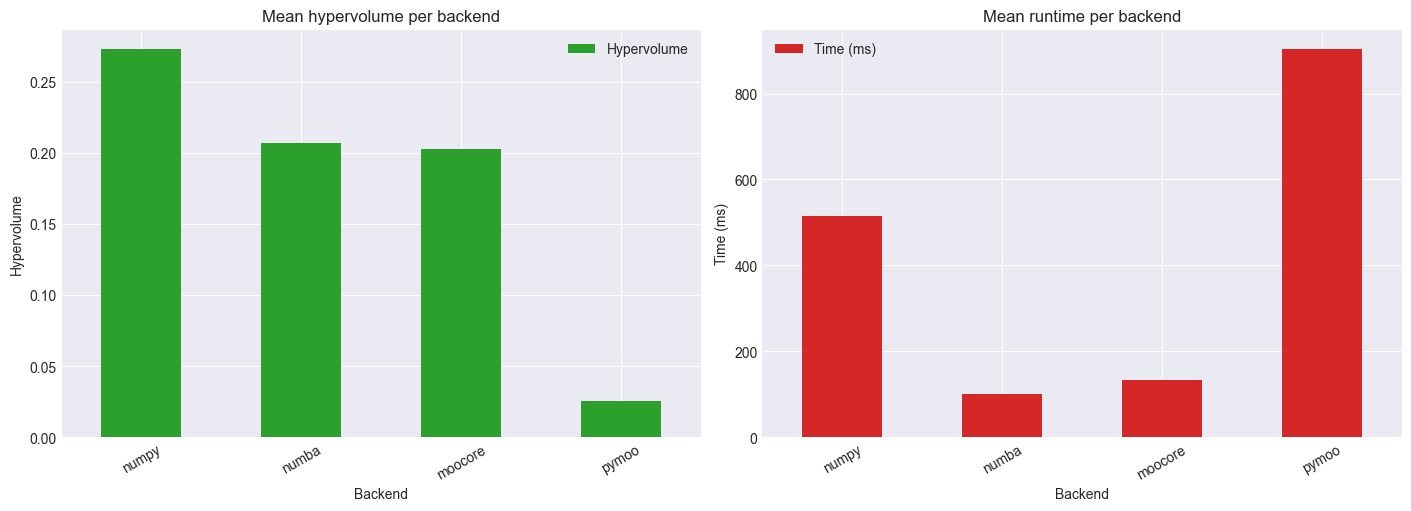

In [43]:
if summary_df.empty:
    raise RuntimeError("No summary data available for backend aggregation.")

backend_agg = (
    summary_df.groupby("Backend")
    .agg(
        Runs=("Backend", "count"),
        Problems=("Problem", "nunique"),
        Hypervolume=("Hypervolume", "mean"),
        Time_ms=("Time (ms)", "mean"),
        Eval_s=("Eval/s", "mean"),
    )
    .rename(columns={"Time_ms": "Time (ms)", "Eval_s": "Eval/s"})
    .sort_values("Hypervolume", ascending=False)
)

display(backend_agg)

backend_plot = backend_agg.reset_index()
fig, axes = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)
backend_plot.plot.bar(x="Backend", y="Hypervolume", ax=axes[0], color="#2ca02c")
axes[0].set_title("Mean hypervolume per backend")
axes[0].set_ylabel("Hypervolume")
axes[0].set_xlabel("Backend")

backend_plot.plot.bar(x="Backend", y="Time (ms)", ax=axes[1], color="#d62728")
axes[1].set_title("Mean runtime per backend")
axes[1].set_ylabel("Time (ms)")
axes[1].set_xlabel("Backend")

for ax in axes:
    ax.tick_params(axis="x", rotation=30)